In [1]:
# dependencies
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np

In [2]:
# read in dataset
batter = pd.read_csv('data/batter_clean.csv')

# check column datatypes
print(batter.dtypes)

# check dataset
batter.head()

p_throws              object
pitch_type            object
release_pos_x        float64
release_pos_z        float64
release_speed        float64
effective_speed      float64
release_spin_rate    float64
release_extension    float64
plate_x              float64
plate_z              float64
balls                  int64
strikes                int64
events                object
dtype: object


,p_throws,pitch_type,release_pos_x,release_pos_z,release_speed,effective_speed,release_spin_rate,release_extension,plate_x,plate_z,balls,strikes,events
0,R,FF,-2.42,3.73,86.2,87.0,2439.0,6.8,0.06,3.04,1,0,home_run
1,R,SI,-2.15,3.59,86.8,87.2,2209.0,6.8,1.51,2.48,0,0,ball
2,R,SI,-2.88,5.37,95.5,96.0,2035.0,6.5,-0.85,2.00,2,2,single
3,R,SI,-2.86,5.38,93.3,93.6,2081.0,6.5,-0.81,1.68,2,2,strike
4,R,SL,-2.86,5.30,89.4,90.2,2257.0,6.6,-0.14,3.18,2,2,strike


In [3]:
# create dummy variables from string values
model_data = pd.get_dummies(batter, columns = ['p_throws', 'pitch_type'])

# drop NA values
model_data.dropna(inplace = True)

# reset index
model_data.reset_index(inplace = True, drop = True)

# set target variable
target = model_data['events']

# drop target variable from model data
model_data.drop(columns = ['events'], inplace = True)

# preview data
model_data.head()

,release_pos_x,release_pos_z,release_speed,effective_speed,release_spin_rate,release_extension,plate_x,plate_z,balls,strikes,...,pitch_type_CS,pitch_type_CU,pitch_type_FC,pitch_type_FF,pitch_type_FS,pitch_type_FT,pitch_type_KC,pitch_type_KN,pitch_type_SI,pitch_type_SL
0,-2.42,3.73,86.2,87.0,2439.0,6.8,0.06,3.04,1,0,...,0,0,0,1,0,0,0,0,0,0
1,-2.15,3.59,86.8,87.2,2209.0,6.8,1.51,2.48,0,0,...,0,0,0,0,0,0,0,0,1,0
2,-2.88,5.37,95.5,96.0,2035.0,6.5,-0.85,2.00,2,2,...,0,0,0,0,0,0,0,0,1,0
3,-2.86,5.38,93.3,93.6,2081.0,6.5,-0.81,1.68,2,2,...,0,0,0,0,0,0,0,0,1,0
4,-2.86,5.30,89.4,90.2,2257.0,6.6,-0.14,3.18,2,2,...,0,0,0,0,0,0,0,0,0,1


In [4]:
# split data into train & test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(model_data, target, random_state = 44)

In [5]:
# run preliminary model using basic parameters
from sklearn.ensemble import RandomForestClassifier

rf_prelim = RandomForestClassifier(random_state = 44)

rf_prelim = rf_prelim.fit(X_train, y_train)

rf_prelim.score(X_test, y_test)

0.7052518756698821

In [6]:
# grid search with cross validation
from sklearn.model_selection import GridSearchCV

# create the parameter grid
param_grid = {
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4],
    'min_samples_split': [3, 5, 7, 9],
    'n_estimators': [100, 200, 300, 400]
}

# create a base model
rf_gs = RandomForestClassifier(random_state = 23)

# instantiate the grid search model
grid_search = GridSearchCV(estimator = rf_gs, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

# fit the grid search
grid_search.fit(X_train, y_train)

# view the best parameters
grid_search.best_params_

Fitting 3 folds for each of 320 candidates, totalling 960 fits


C:\Users\spenc\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:  2.1min finished


{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 300}

In [7]:
# run model using grid search parameters
rf_gs_params = RandomForestClassifier(max_depth = 10, min_samples_leaf = 1, 
                                      min_samples_split = 5, n_estimators = 300,
                                      random_state = 44)
rf_gs_params = rf_gs_params.fit(X_train, y_train)
rf_gs_params.score(X_test, y_test)

0.6988210075026795

In [8]:
# test efficacy of features
from collections import defaultdict
from sklearn.model_selection import ShuffleSplit
from tqdm import tqdm

r = np.random.RandomState(44)

# create cv splits
features = model_data.columns.values
rs = ShuffleSplit(n_splits = 100, test_size = 0.3, random_state = 44)

# store data
X = model_data
Y = target

scores = defaultdict(list)

# loop through cv splits, compare default accuracy to accuracy with features removed
for train_idx, test_idx in tqdm(rs.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
    
    acc = rf_gs_params.score(X_test, Y_test)
    
    for i in range(X.shape[1]):
        X_t = X_test.copy(deep = True)
        r.shuffle(X_t.iloc[:, i].values)
        shuff_acc = rf_gs_params.score(X_t, Y_test)
        scores[features[i]].append((acc - shuff_acc) / acc)

# build lists for dictionary
mda_features = [f for f in scores.keys()]
mda_importance = [(np.mean(score)) for score in scores.values()]
mda_indices = np.argsort(mda_importance)

# create dataframe using dictionary
mda_df = pd.DataFrame({'feature': mda_features,
                       'importance': mda_importance})

100it [01:30,  1.11it/s]


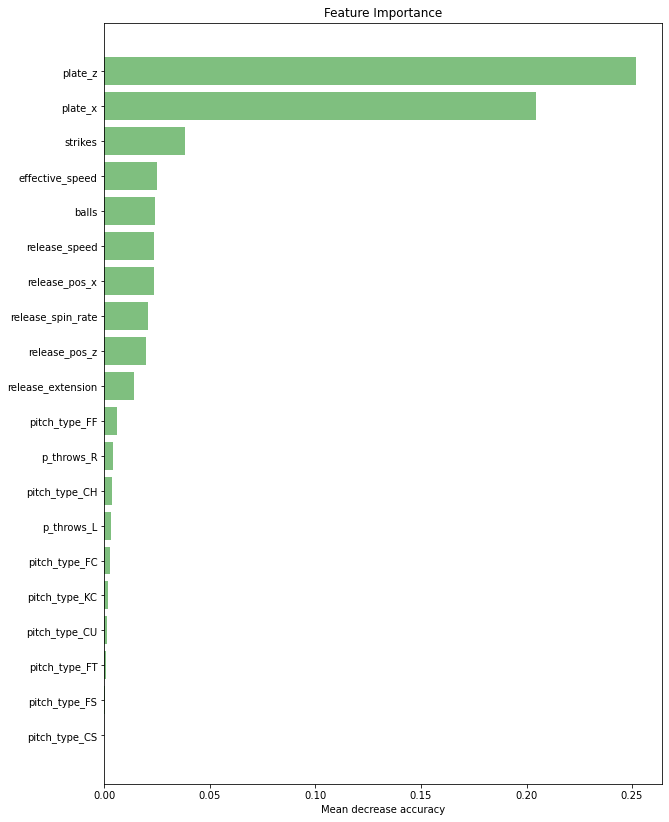

In [9]:
# visualize feature data, sorted from largest decrease in accuracy when removed to smallest 
import matplotlib.pyplot as plt

# create the figure
plt.figure(figsize = (10,14))

# title
plt.title('Feature Importance')

# bar plot
plt.barh(range(len(mda_indices)), [mda_importance[i] for i in mda_indices], color='green', alpha = 0.5, align='center')

# set y-ticks
plt.yticks(range(len(mda_indices)), [mda_features[i] for i in mda_indices])

# x-axis label
plt.xlabel('Mean decrease accuracy')

# show plot
plt.show()